In [1]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation,TimeDistributed
from keras.layers import Bidirectional, LSTM
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate,BatchNormalization
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, RepeatVector, Permute, merge
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import concatenate
from keras.callbacks import *
from keras.utils import to_categorical


Using TensorFlow backend.


In [2]:
import keras
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)

keras.backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
# google word2vec
from gensim.models import KeyedVectors as wv
word_vectors1 = wv.load_word2vec_format('./input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary = True)
EMBEDDING_DIM =300

#glove
word_vectors2 = {}
f = open('./input/embeddings/glove.840B.300d/glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    word_vectors2[word] = coefs
f.close()
EMBEDDING_DIM =300

# print('Found %s word vectors.' % len(embeddings_index))

In [4]:
# df_train = pd.read_csv("./input/train.csv")
# df_test = pd.read_csv("./input/test.csv")

df = pd.read_csv("./input/train.csv")
df_train, df_test = train_test_split(df, test_size=0.2,random_state=1)
print("Train shape : ",df_train.shape)
print("Test shape : ",df_test.shape)

df_train_pos = df_train[df_train['target']==1]
df_train_neg = df_train[df_train['target']==0].sample(len(df_train_pos)*5,random_state=1)
df_train = pd.concat([df_train_pos,df_train_neg])
df_train = df_train.sample(frac=1,random_state=1)
print("Train shape : ",df_train.shape)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

MAX_SEQUENCE_LENGTH=180


tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(df_train['question_text'])
sequences = tokenizer.texts_to_sequences(df_train['question_text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

train_X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
train_Y = df_train['target']

sequences = tokenizer.texts_to_sequences(df_test['question_text'])
test_X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
test_Y = df_test['target']
# labels = to_categorical(np.asarray(labels))
# print('Shape of data tensor:', data.shape)
# print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]
# nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

# x_train = data[:-nb_validation_samples]
# y_train = labels[:-nb_validation_samples]
# x_val = data[-nb_validation_samples:]
# y_val = labels[-nb_validation_samples:]

Train shape :  (1044897, 3)
Test shape :  (261225, 3)
Train shape :  (387192, 3)


/home/samarth/anaconda3/envs/tensorflow36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Found 133472 unique tokens.


In [5]:

df_train.iloc[4]['question_text']

'What can make you effective teacher?'

73.65645984421165
62.0
41.84467927436718
1017


(array([3.15713e+05, 6.37790e+04, 7.69500e+03, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([1.000e+00, 1.026e+02, 2.042e+02, 3.058e+02, 4.074e+02, 5.090e+02,
        6.106e+02, 7.122e+02, 8.138e+02, 9.154e+02, 1.017e+03]),
 <a list of 10 Patch objects>)

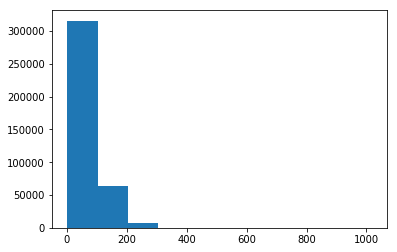

In [6]:
lengths = []
for sent in df_train['question_text']:
#     print(sent)
    lengths.append(len(sent))
#     if max(sent)>50:
#         print(sent)
print(np.mean(lengths))
print(np.median(lengths))
print(np.std(lengths))
print(np.max(lengths))
plt.hist(lengths,density=False)

In [7]:
#for google word2vec

embedding_matrix1 = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        word_vector1 = word_vectors1[word]
#     if word_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix1[i] = word_vector1
    except KeyError:
        continue
        
embedding_matrix2 = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        word_vector2 = word_vectors2[word]
#     if word_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix2[i] = word_vector2
    except KeyError:
        continue

In [8]:
# print(train_X_raw[0])
print(train_X.shape)
print(train_Y.shape)
# print(tokenizer.word_index)

(387192, 180)
(387192,)


In [9]:
def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    # So we only measure F1 on the target y value:
    y_true = y_true[:, 0]
    y_pred = y_pred[:, 0]
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

## Attention Layer

In [10]:
from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim
        

## LSTM+Attention  - Single embedding

In [11]:
##model definition
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix1],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))


# model.add(CuDNNLSTM(75, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Bidirectional(CuDNNLSTM(150, return_sequences=True), input_shape=(train_X.shape[1], EMBEDDING_DIM)))
model.add(Dropout(0.4))
model.add(Bidirectional(CuDNNLSTM(100, return_sequences=False)))#, input_shape=(train_X.shape[1], EMBEDDING_DIM)))
# model.add(Attention(MAX_SEQUENCE_LENGTH))
# model.add(Flatten())
# model.add(TimeDistributed(Dense(100,activation='relu')))
model.add(Dropout(0.4))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 180, 300)          40041900  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 180, 300)          542400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 180, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               321600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________

In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])  

In [ ]:
model.fit(train_X, train_Y, epochs=10,batch_size=500,validation_split=0.1)

Train on 348472 samples, validate on 38720 samples
Epoch 1/10
348472/348472 [==============================] - 161s 462us/step - loss: 0.2159 - acc: 0.9130 - f1: 0.7214 - val_loss: 0.1860 - val_acc: 0.9260 - val_f1: 0.7646
Epoch 2/10
348472/348472 [==============================] - 163s 469us/step - loss: 0.1846 - acc: 0.9267 - f1: 0.7760 - val_loss: 0.1748 - val_acc: 0.9295 - val_f1: 0.7884
Epoch 3/10
348472/348472 [==============================] - 163s 469us/step - loss: 0.1723 - acc: 0.9321 - f1: 0.7944 - val_loss: 0.1697 - val_acc: 0.9318 - val_f1: 0.7979
Epoch 4/10
348472/348472 [==============================] - 163s 468us/step - loss: 0.1617 - acc: 0.9361 - f1: 0.8073 - val_loss: 0.1665 - val_acc: 0.9336 - val_f1: 0.7988
Epoch 5/10
348472/348472 [==============================] - 163s 468us/step - loss: 0.1510 - acc: 0.9404 - f1: 0.8206 - val_loss: 0.1691 - val_acc: 0.9348 - val_f1: 0.8001
Epoch 6/10
348472/348472 [==============================] - 163s 468us/step - loss: 0.139

In [29]:
preds= model.predict_classes(test_X,verbose=1,batch_size=1000)
print(metrics.f1_score(test_Y, preds))
# pred_cnn_val_y = model.predict([val_X], batch_size=1024, verbose=1)


261225/261225 [==============================] - 37s 143us/step
0.6442800227660785


## LSTM+Attention  - Multiple embedding

In [12]:
##model definition
input_shape = (MAX_SEQUENCE_LENGTH,)
model_input = Input(shape=input_shape)

z1 = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix1],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(model_input)
z1 = Bidirectional(CuDNNLSTM(150, return_sequences=False), input_shape=(train_X.shape[1], EMBEDDING_DIM))(z1)

z2 = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix2],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(model_input)
z2 = Bidirectional(CuDNNLSTM(150, return_sequences=False), input_shape=(train_X.shape[1], EMBEDDING_DIM))(z2)

m = Concatenate()([z1,z2])
m = Dropout(0.4)(m)
m = Dense(100,activation='relu')(m)
m = Dropout(0.4)(m)
model_output = Dense(1, activation="sigmoid")(m)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy",f1])

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 180)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 180, 300)     40041900    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 180, 300)     40041900    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 300)          542400      embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectio

In [15]:
model.fit(train_X, train_Y, epochs=10,batch_size=500,validation_split=0.1)

Train on 348472 samples, validate on 38720 samples
Epoch 1/10
348472/348472 [==============================] - 172s 492us/step - loss: 0.1251 - acc: 0.9512 - f1: 0.8549 - val_loss: 0.1791 - val_acc: 0.9315 - val_f1: 0.7925
Epoch 2/10
348472/348472 [==============================] - 178s 511us/step - loss: 0.1159 - acc: 0.9555 - f1: 0.8682 - val_loss: 0.1976 - val_acc: 0.9298 - val_f1: 0.7840
Epoch 3/10
348472/348472 [==============================] - 178s 510us/step - loss: 0.1067 - acc: 0.9592 - f1: 0.8790 - val_loss: 0.1977 - val_acc: 0.9292 - val_f1: 0.7868
Epoch 4/10
348472/348472 [==============================] - 181s 519us/step - loss: 0.0982 - acc: 0.9625 - f1: 0.8887 - val_loss: 0.2056 - val_acc: 0.9296 - val_f1: 0.7887
Epoch 5/10
348472/348472 [==============================] - 180s 517us/step - loss: 0.0875 - acc: 0.9667 - f1: 0.9015 - val_loss: 0.2267 - val_acc: 0.9292 - val_f1: 0.7865
Epoch 6/10
348472/348472 [==============================] - 177s 508us/step - loss: 0.079

In [16]:
probs= model.predict(test_X,verbose=1,batch_size=500)
preds = np.zeros(len(probs))

preds[probs[:,0]>=0.5] =1 
print(metrics.f1_score(test_Y, preds))


261225/261225 [==============================] - 46s 177us/step
0.6312801589554358


# Bin

In [18]:
for thresh in np.arange(-0.20, 1, 0.05):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(train_Y, (preds>thresh).astype(int))))

F1 score at threshold -0.2 is 0.5
F1 score at threshold -0.15 is 0.5
F1 score at threshold -0.1 is 0.5
F1 score at threshold -0.05 is 0.5
F1 score at threshold -0.0 is 0.5006551699569726
F1 score at threshold 0.05 is 0.9538913433701808
F1 score at threshold 0.1 is 0.9588053741119749
F1 score at threshold 0.15 is 0.9608015640273705
F1 score at threshold 0.2 is 0.9622097119018885
F1 score at threshold 0.25 is 0.9630757144260041
F1 score at threshold 0.3 is 0.9636065150425176
F1 score at threshold 0.35 is 0.9639653505882643
F1 score at threshold 0.4 is 0.9641520716588683
F1 score at threshold 0.45 is 0.964307977164018
F1 score at threshold 0.5 is 0.9644417258274791
F1 score at threshold 0.55 is 0.9646491200940216
F1 score at threshold 0.6 is 0.9645400611848054
F1 score at threshold 0.65 is 0.964271098158368
F1 score at threshold 0.7 is 0.9639306803434937
F1 score at threshold 0.75 is 0.9634884906669319
F1 score at threshold 0.8 is 0.9628457710203242
F1 score at threshold 0.85 is 0.9619818

In [25]:
preds = model.predict_classes(test_X,verbose=1)
# print(metrics.f1_score(train_Y,preds))
print(sum(preds))

56370/56370 [==============================] - 9s 163us/step
[7259]


In [26]:
df_out = pd.DataFrame()
df_out["qid"] = df_test['qid']
df_out["predictions"] = preds
df_out.to_csv("sub.csv",index=False)

In [22]:
sum(preds)

array([81037], dtype=int32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 150, 300)          30870600  
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 150, 280)          495040    
Total params: 31,365,640
Trainable params: 495,040
Non-trainable params: 30,870,600
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 1)                 151       
_________________________________________________________________
activation_20 (Activation)   (None, 1)                 0         
_________________________________________________________________
repeat_vector_28 (RepeatVect (None, 150, 1)            0         
Total params: 151
Trainable params: 151
Non-trainable

/home/samarth/anaconda3/envs/tensorflow36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=150, units=1)`


TypeError: __init__() takes 1 positional argument but 2 were given

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten

model=Sequential()
model.add(Conv2D(10,(3,3)))
model.add(Conv2D(10,(3,3)))
model.add(Flatten())
model.add(Dense(20))
model.add(Dense(10))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
# model.build()
# model.summary()

In [ ]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)

In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

In [ ]:
import string
letter_count = dict(zip(string.ascii_lowercase, [0]*26))

In [ ]:
{chr(i+96):i for i in range(1,27)}

In [ ]:
import keras.layers.`